# 第5章 TensorFlowでニューラルイメージキャプショニング

さらにハイレベルAPIを使用して、ニューラルイメージキャプショニング（NIC）をします。    
画像を入れると説明文を表示してくれる。

【今日得れること】    
データをバイナリ化する（TFRecord形式）    
大規模データセットを使って学習する流れを"知る"    
イメージキャプションのモデルをざっくり"知る" "見る"    
AWSの使い方を"見る"    

【明日以降に得れる可能性のあること】    
自分の環境で動かす    
Jupyterで動かす(今回のjupyterは動きません。)    
この章はjupyterに移すのが非常に手間だった。    
しかしデータも多く、実務に近いと思う


## 画像キャプショニング

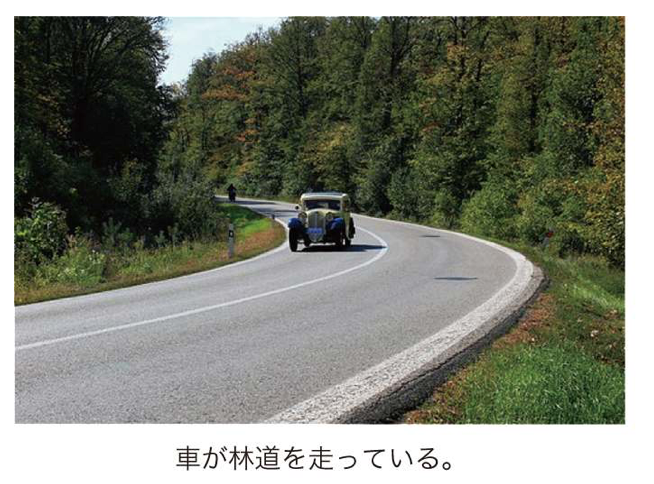

代表モデルとしては2015年googleの出した「show and tell」など。    
画像をCNNを用いて固定長の特徴空間にエンコードして、その特徴を出力側のRNNでデコードして画像の説明を生成

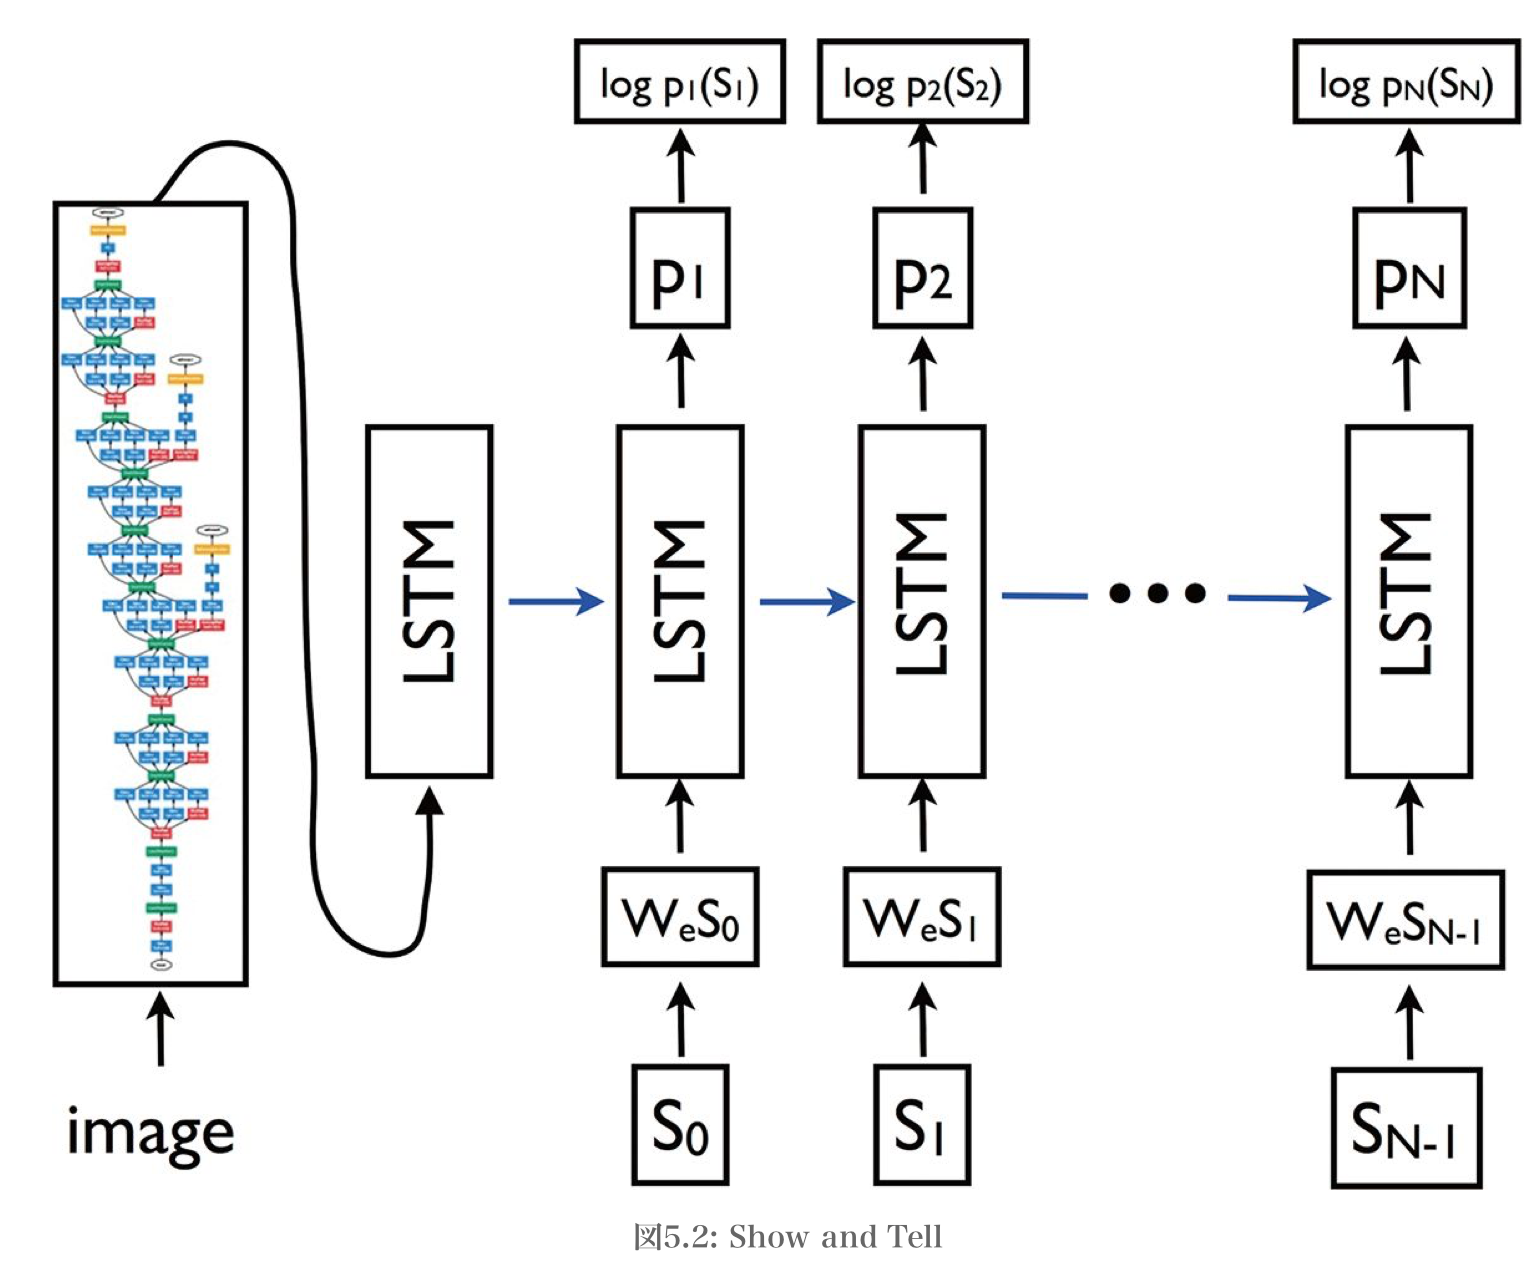

このCNN部分はキャプションを出すために学習した重みではないが、キャプションするための重要な特徴量を出力できる。    
このようにある特定のタスクのために学習したモデルを、別のタスクに使用することを「転移学習」という。    
実際にCNNで学習済みモデルを使わずに学習すると、文字生成がうまくいくようにだけ調整されてしまい、    
どの画像を入れても同じエンコード結果になるようになったそう。


## MS COCOデータセット

ダウンロード対象は「2014TrainImages」と「2014ValImages」の2つ。    
サイズも合わせて20GB程度    

2014 Train images [83K/13GB]
2014 Val images [41K/6GB]


でかい。。


floydで良いやと思ったら、日本語データもやるみたいなので諦めてawsで。    

  
```
floyd init miyamotok0105/study_tensorflow_imagecap_coco1

floyd run <insert-command-here> 
# To use GPU 
floyd run --gpu <insert-command-here> 
# To use a different environment 
floyd run --gpu --env pytorch <insert-command-here> 

```

AWSなどクラウドを使うとお金がかかりますが、諦めました。    
知り合いも月に10万位以上学習用サーバーに使ってるようで、後から給料高くなると良いなて感じで諦めます。    

DL用のAWSを選ぶ。

```
Deep Learning AMI (Ubuntu) Version 9.0 - ami-8024aaff
Comes with latest binaries of deep learning frameworks pre-installed in separate virtual environments: MXNet, TensorFlow, Caffe, Caffe2, PyTorch, Keras, Chainer, Theano and CNTK. Fully-configured with NVidia CUDA, cuDNN and NCCL as well as Intel MKL-DNN

```

環境切り替え

```
source activate tensorflow_p36
```

cocoデータ取得

```
wget http://images.cocodataset.org/zips/train2014.zip
wget http://images.cocodataset.org/zips/val2014.zip

```

cocoデータを日本語にしてくれたやつ

```
「 STAIR Caption」
https://stair-lab-cit.github.io/STAIR-captions-web/
git clone https://github.com/STAIR-Lab-CIT/STAIR-captions.git

git checkout deaaa3f5198f9bbedc1c090244e25d8305d3265f
tar -zxvf stair_captions_v1.1_train.json.tar.gz
tar -zxvf stair_captions_v1.1_val.json.tar.gz
mkdir data/tfrecords
```


## 大規模データセットの注意

今回のデータセットは数十GBのため、全てをメモリにロードすることができないため、全てplaceholder経由で入力・正解データのミニバッチの受け渡しをすることはできない。全てをメモリーに展開できない。    

ミニバッチはハードディスクから都度データを取得して加工する必要があるが、ディスクIOが発生し非常に時間がかかる。メモリアクセスはディスクIOの100分の１から1000分の１の速度。毎エポックこれが発生するとミニバッチの作成がボトルネックになり、学習に時間がかかる。    

特にイメージキャプショニングのモデルは収束に時間がかかる。そのため学習を行うスレッドとデータセットを作成するスレッドを分割して、キューイングすることで学習している間にミニバッチを作成するのが定石。     

もう一つの方法としてはデータをバイナリで固める方法がある。また画像、キャプション文字列を一緒にバイナリに固めればその後の実装もシンプルになる。

## TFRecord形式によるデータのバイナリ化

tfrecord/img以下にjpg画像を入れる。    
データセットのバイナリ化をする。    


In [ ]:
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。

書き込み処理

In [10]:
#-*- coding:utf-8 -*-

import glob
import tensorflow as tf


#jpegファイルのパスを取得
img_list = [i for i in glob.glob('./tfrecord/img/*.jpg')]

print(img_list)

#test.tfrecordこの名前でファイルが出力される
with tf.python_io.TFRecordWriter('test.tfrecord') as w:

    for img in img_list:

        #ファイルをバイナリとして読み込み bオプションを忘れないように。
        with tf.gfile.FastGFile(img, 'rb') as f:
            data = f.read()

        #取得したbyte列をkey,valueに登録
        #Features：キーバリュー形式で登録を行うクラス
        #{}の中には複数入れれる。bytes, int, floatの３種。
        features = tf.train.Features(feature={
            'data':tf.train.Feature(bytes_list=tf.train.BytesList(value=[data]))
        })

        #Exampleクラスにkey, valueを登録して書き込み
        #ここに入るfeaturesのリストの長さは固定にすること。
        #バラバラでもTFRecordは生成できるが、デコードでおかしなことになる。
        example = tf.train.Example(features=features)
        w.write(example.SerializeToString())

['./tfrecord/img/jpg.jpg']


バイナリ化したものを読み込む

In [ ]:
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。

/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


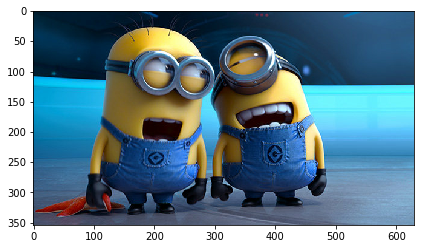

In [13]:
#-*- coding:utf-8 -*-

import tensorflow as tf
from skimage import io

def parse(example):

    #TFRecordをパース
    features = tf.parse_single_example(
        example,
        features={
            #今回は画像のバイト列が１件だけなのでshapeは[]になる
            'data': tf.FixedLenFeature([], dtype=tf.string)
        })
    #バイト列のままになっているので元の画像の形式に変換
    img = features['data']
    img = tf.image.decode_jpeg(img)
    return img


#バイナリを読み込むのにTFRecordDatasetを使用
#TFRecordファイルを読み込みパース用の関数を適用
dataset = tf.data.TFRecordDataset(['test.tfrecord']).map(parse)

#データセットを1周するイテレータ
iterator = dataset.make_one_shot_iterator()
#イテレータから要素を取得
next_element = iterator.get_next()

with tf.Session() as sess:
    #データセットから画像を1件取得
    jpeg_img = sess.run(next_element)
    #scikit-imageで表示
    io.imshow(jpeg_img)
    io.show()




## データセット整形

プログラム概要

1.STAIR Captionsのファイルを読み込んで画像idからファイルぱすとキャプション用の辞書を作る    
2.学習と検証、テスト用にデータを分割    
3.学習のデータセットを元に単語辞書を作成    
4.画像を読み込みTFRecord形式で画像とキャプションの組み合わせを１レコードとしてTFRecordに書き込む    

以下データセットが大きいため、他の環境で動かす前提。    
ソースは解説用にメモ。　   


data/img/train2014/    
data/img/val2014/    
data/stair_captions_v1.1_train.json    
この構成は作っておく    



dataフォルダ以下にファイルを置いて置くこと。    

データセットを作る。


```
TensorFlowDL-samples/nic
python create_data_sets.py
```

実行は１０分程かかる。1つ１つのファイルは70MB程。

In [ ]:
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。

In [9]:
# -*- coding:utf-8 -*-

import os
import json
import numpy as np
from collections import namedtuple, Counter
import tensorflow as tf

train_img_dir = "nic/data/img/train2014/"
val_img_dir = "nic/data/img/val2014/"
train_captions = "nic/data/stair_captions_v1.1_train.json"
val_captions = "nic/data/stair_captions_v1.1_val.json"
out_dir = "nic/data/tfrecords/"
min_word_count = 4
word_list_file = "nic/data/dictionary.txt"


単語を扱う場合に「文章開始」、「文章終了」、「不明文字」の３つの特殊文字を使用する。


In [10]:
START_WORD = '<S>'
END_WORD = '<E>'
UNKNOWN_WORD = '<UNW>'

NUM_TRAIN_FILE = 256
NUM_VAL_FILE = 4
NUM_TEST_FILE = 8

JSONのパースは画像から行い、取得した画像のidから対になるキャプションを見つけてword idを見つけて「画像+文字id一覧」のデータを作成。

In [ ]:
#jsonファイルを読み込み画像のid, ファイル名, キャプションを取得する。
def _load_metadata(caption_filename, img_dir):

    #jsonファイルをロード
    with open(caption_filename, 'r') as f:
        meta_data = json.load(f)

    #画像idとファイル名を持つnamedtupleのリストを作成
    meta_list = [ImageMetadata(x['id'], os.path.join(img_dir, x['file_name'])) for x in meta_data['images']]

    #スペース区切りのcaptionを単語の配列に変換
    def _create_word_list(caption):
        tokenized_captions = [START_WORD]
        tokenized_captions.extend(caption.split())
        tokenized_captions.append(END_WORD)
        return tokenized_captions

    #{画像id => キャプションのリスト}の辞書を作成
    id_to_captions = {}
    for annotation in meta_data["annotations"]:
        img_id = annotation['image_id']
        caption = annotation['tokenized_caption']
        caption = _create_word_list(caption)
        #キャプションはいくつかあるため１つだけを採用
        id_to_captions[img_id] = caption

    print("Loaded caption metadata for %d images from %s" % (len(meta_list), caption_filename))

    return meta_list, id_to_captions

val_meta, val_captions = _load_metadata(val_captions, val_img_dir)


In [ ]:

def _create_vocab(captions):

    counter = Counter()
    for c in captions:
        counter.update(c)

    print("total words:", len(counter))
    #出現回数が一定数のものだけ辞書に採用。出現回数降順でソート
    #word_countsは(単語, 出現回数)のリスト
    word_counts = [x for x in counter.items() if x[1] >= min_word_count]
    word_counts.sort(key=lambda x: x[1], reverse=True)
    print("Words in vocab:", len(word_counts))


    #辞書作成
    word_list = [x[0] for x in word_counts]
    #<S>と<E>のidを1,0で固定したいので、一度削除して先頭に追加する
    word_list.remove(START_WORD)
    word_list.remove(END_WORD)
    word_list.insert(0, START_WORD)
    word_list.insert(0, END_WORD)

    word_list.append(UNKNOWN_WORD)
    word_to_id = dict([(x, y) for (y, x) in enumerate(word_list)])
    id_to_word = dict([(x, y) for (x, y) in enumerate(word_list)])
    return word_to_id, id_to_word


In [11]:
ImageMetadata = namedtuple("ImageMetadata",["img_id", "filename"])

#画像メタデータと辞書をもとに、指定されたファイル数に分割してバイナリ（TFRecord）を作成する
def _create_datasets(name, img_meta, captions, word_to_id, num_file):

    #画像メタデータをだいたい等しく分割
    #NUM_TRAIN_FILE, NUM_VAL_FILE, NUM_TEST_FILEの設定をnum_fileに入れて分割
    #img_chunkにnum_fileの数で分割されたのが入る
    img_chunk = np.array_split(img_meta, num_file)
    counter = 0
    for i in range(1, num_file + 1):
        output_file_name = "%s-%.3d.tfrecord" % (name, i)
        output_file_path = os.path.join(out_dir, output_file_name)
        target_chunk = img_chunk[counter]
        #対象画像ごとにWriterを定義
        with tf.python_io.TFRecordWriter(output_file_path) as writer:
            for img in target_chunk:
                img_id = img[0]
                filename = img[1]
                #画像ファイルをバイト列として読み込み
                with tf.gfile.FastGFile(filename, "rb") as f:
                    data = f.read()

                #キャプションのid化
                caption = captions[int(img_id)]
                caption_ids = []
                for w in caption:
                    if w in word_to_id:
                        caption_ids.append(word_to_id[w])
                    else:
                        #見つからない文字の場合
                        caption_ids.append(word_to_id[UNKNOWN_WORD])

                #固定長部分
                context = tf.train.Features(feature={
                    "img_id": tf.train.Feature(int64_list=tf.train.Int64List(value=[int(img_id)])),
                    "data": tf.train.Feature(bytes_list=tf.train.BytesList(value=[data])),
                    })

                #可変長部分
                caption_feature = [tf.train.Feature(int64_list=tf.train.Int64List(value=[v])) for v in caption_ids]
                feature_lists = tf.train.FeatureLists(feature_list={
                    "caption":tf.train.FeatureList(feature=caption_feature)
                    })

                #TFRecordに書き込み
                #contextに画像、feature_listsにキャプション文字列のID一覧
                #可変長のデータの場合はtf.train.Exampleではなく、tf.train.SequenceExampleを使用
                sequence_example = tf.train.SequenceExample(context=context, feature_lists=feature_lists)
                writer.write(sequence_example.SerializeToString())

        counter += 1

In [ ]:

def main(argv):

    #jsonファイルからメタデータの読み込み
    #(画像id, ファイルパス)のタプルの配列と{id=>キャプションのリスト}を取得
    train_meta, train_captions = _load_metadata(train_captions, train_img_dir)
    val_meta, val_captions = _load_metadata(val_captions, val_img_dir)

    #キャプションをマージ
    captions = {k:v for dic in [train_captions, val_captions] for k, v in dic.items()}

    #訓練データ,バリデーションデータ,テストデータに分割
    train_cutoff = int(0.85 * len(val_meta))
    val_cutoff = int(0.90 * len(val_meta))
    #trainとvalを合算して、再分割し少し学習データを多くした。
    train_dataset = train_meta + val_meta[0:train_cutoff]
    val_dataset = val_meta[train_cutoff:val_cutoff]
    test_dataset = val_meta[val_cutoff:]


    #訓練データから辞書作成
    train_captions = []
    for meta in train_dataset:
        c = captions[meta.img_id]
        train_captions.append(c)

    word_to_id, id_to_word = _create_vocab(train_captions)


    #画像を読み込みメタデータと結合したバイナリを作成
    _create_datasets("train", train_dataset, captions, word_to_id, NUM_TRAIN_FILE)
    _create_datasets("val", val_dataset, captions, word_to_id, NUM_VAL_FILE)
    _create_datasets("test", test_dataset, captions, word_to_id, NUM_TEST_FILE)

    # 単語リスト出力
    with open(word_list_file, 'a') as f:
        for k, v in id_to_word.items():
            f.write(v)
            f.write('\n')


In [ ]:

if __name__ == "__main__":
    tf.app.run()


## GoogLeNet Inception-v3の転移学習　学習済みモデルの利用

inceptionモジュールを使用。
何層にするか、畳み込みのフィルターサイズ、ユニット数、プーリングのタイミング、などのハイパーパラメータは「どの値にしてもそれぞれ別の重要な特徴を抽出できる」。    
inceptionモジュールは異なるパターンを結合してしまうという発想。    
1*1畳み込みはパラメータ数の圧縮の畳み込み。    

詳細は本を参照。    

## inception-v3の書き出し

学習済みのProtocol Buffers形式(pb形式)のファイルを使用する。    

tfサイトから取得できる。    
https://github.com/tensorflow/models/tree/master/research/slim    
下記に保存。    

```
wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
tar -zxvf inception_v3_2016_08_28.tar.gz

```

ckpt/inception_v3.ckpt    

ckpt形式をpb形式に固める。


```

python create_inception_v3_pb.py
```


In [ ]:
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。

In [ ]:
# -*- coding:utf-8 -*-
tf.logging.log
import tensorflow as tf
import inception_v3 as iv3

FLAGS = tf.flags.FLAGS
tf.flags.DEFINE_string("ckpt_file", 'ckpt/inception_v3.ckpt', "Inception-v3 checkpoint file.")
tf.flags.DEFINE_string('log_dir', 'logs/', "TensorBoard log directory.")
tf.flags.DEFINE_string('output_dir', './', "Output directory.")
tf.flags.DEFINE_string('output_file', 'inception_v3.pb', "Output file name.")

#　Inception-v3を読み込み
input_img = tf.placeholder(tf.float32,[None, 299, 299, 3], name='input_image')
arg_scope = iv3.inception_v3_arg_scope()
with tf.contrib.slim.arg_scope(arg_scope):
    logits, end_points = iv3.inception_v3(inputs=input_img, is_training=False, num_classes=1001)

#　計算グラフ取得
graph = tf.get_default_graph()

#　TensorBordで確認できるように
writer = tf.summary.FileWriter(FLAGS.log_dir, graph)
writer.close()

#　pb形式で書き出し
tf.train.write_graph(graph, FLAGS.output_dir, FLAGS.output_file)
saver = tf.train.Saver()

with tf.Session() as sess:
    #チェックポイントが読み込めるか念のために確認
    saver.restore(sess, FLAGS.ckpt_file)

## freeze_graph.pyの使用

前節で作ったpbファイルは形を書き出しただけで、訓練済みのパラメータと紐づいてはいない。

freeze_graph.pyはpbファイルとチェックポイントファイルを読み込んで、計算グラフ上のtf.Variable()をチェックポイントに記載された値に書き換えtf.constant()に変換して永久保存モデルを作成するツール。    
このpbファイルはpython以外のモバイル上や、その他のでデバイスで動く。    




学習スクリプト→推定用pbファイル＋チェックポイントファイル→freeze_graph.py→実行用pbファイル


実行すると inception_v3_freezed.pbファイルが出力される。    


```

これでよし
python freeze_graph.py --input_graph=inception_v3.pb --input_checkpoint=ckpt/inception_v3.ckpt --output_node_names=InceptionV3/Predictions/Reshape --output_graph=inception_v3_freezed.pb


```


これで訓練済みモデルによる転移学習を行う用意が整った。




# Neural Machine Translation (seq2seq) Tutorial

その前に

https://www.tensorflow.org/tutorials/seq2seq

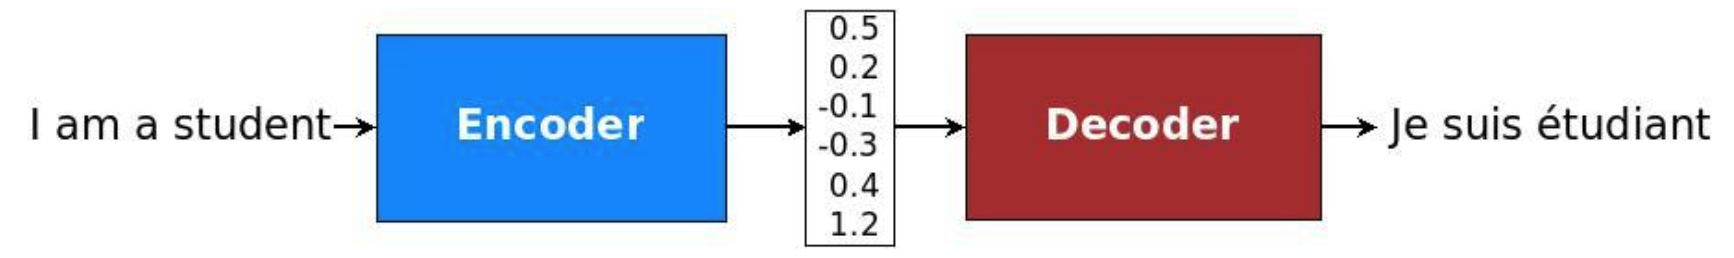

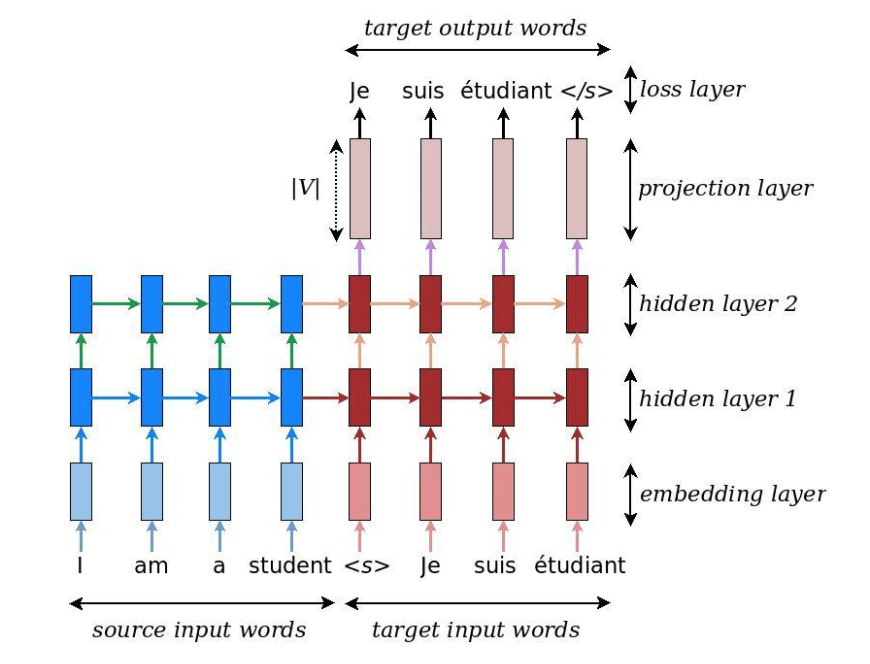

encoder_inputs [max_encoder_time, batch_size]:     
decoder_inputs [max_decoder_time, batch_size]:     
decoder_outputs [max_decoder_time, batch_size]:    

## Embedding

何かしらの文字埋め込み層を入力にする

In [ ]:
# Embedding
embedding_encoder = variable_scope.get_variable(
    "embedding_encoder", [src_vocab_size, embedding_size], ...)
# Look up embedding:
#   encoder_inputs: [max_time, batch_size]
#   encoder_emb_inp: [max_time, batch_size, embedding_size]
encoder_emb_inp = embedding_ops.embedding_lookup(
    embedding_encoder, encoder_inputs)

## Encoder

BasicLSTMCellとdynamic_rnnで構成。

In [ ]:
# Build RNN cell
encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)

# Run Dynamic RNN
#   encoder_outputs: [max_time, batch_size, num_units]
#   encoder_state: [batch_size, num_units]
encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_emb_inp,
    sequence_length=source_sequence_length, time_major=True)

## Decoder

seq2seq.BasicDecoderにBasicLSTMCellとTrainingHelperを入れる。    
seq2seq.BasicDecoderをseq2seq.dynamic_decodeに入れる。    
イメージキャプションでseq2seq.BasicDecoder、seq2seq.dynamic_decodeがでてくる。

In [ ]:
# Build RNN cell
decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)

projection_layer = layers_core.Dense(
    tgt_vocab_size, use_bias=False)

In [ ]:
# Helper
helper = tf.contrib.seq2seq.TrainingHelper(
    decoder_emb_inp, decoder_lengths, time_major=True)
# Decoder
decoder = tf.contrib.seq2seq.BasicDecoder(
    decoder_cell, helper, encoder_state,
    output_layer=projection_layer)
# Dynamic decoding
outputs, _ = tf.contrib.seq2seq.dynamic_decode(decoder, ...)
logits = outputs.rnn_output

## Loss

decoder_outputsをsoftmaxでつなぐ

In [ ]:
crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=decoder_outputs, logits=logits)
train_loss = (tf.reduce_sum(crossent * target_weights) /
    batch_size)

## Gradient computation & optimization

In [ ]:
# Calculate and clip gradients
params = tf.trainable_variables()
gradients = tf.gradients(train_loss, params)
clipped_gradients, _ = tf.clip_by_global_norm(
    gradients, max_gradient_norm)

In [ ]:
# Optimization
optimizer = tf.train.AdamOptimizer(learning_rate)
update_step = optimizer.apply_gradients(
    zip(clipped_gradients, params))

## キャプション生成モデル

モデル概要：    
入力画像をinception-v3モジュールを通して最終層の手前の層で全結合でRNN（1001ユニット）に繋げる。    
画像を最初の時刻の入力にして、その出力はRNN中間層の初期値にする。    
以降のRNNへの入力は単語埋め込みベクトル達。最初と最後の文字は特殊文字。    


・テクニック    
普通に実装するとRNNの学習では全時刻の推論データを次の学習にしようする。    
だが初めは間違った文字が出力されるので長期時系列の学習は時間がかかる。    
なのでRNNの各時刻の入力を前出力の正解データにしておく。    
これをTeacherForcingという。    

・時系列長の違い    
学習はミニバッチで行うので入力ごとに出力される時系列長が違う。    
Tensorはサイズの違う要素を含めない。    
最大長のものに合わせておいて、途中で文章終了させてしまう。


```
転移学習の用意が終わり。

data/img/for_eval/
にテスト用の画像を入れておく


TensorFlowDL-samples/nic/create_inception_v3

python im2txt.py

python freeze_graph.py --input_binary=true --input_checkpoint ../ckpt/mymodel --output_node_names=captioning/decoder/transpose_1 --output_graph=im2txt.pb --input_graph=../data/infer_graph.pb


python inference.py --target_img data/img/for_eval/COCO_val2014_000000183843.jpg


```


In [ ]:
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。
#※　発表用のコードです。このJupyterは動きません。

In [ ]:
# -*- coding:utf-8 -*-

import glob
import tensorflow as tf
from PIL import Image
import numpy as np 


FLAGS = tf.flags.FLAGS
tf.flags.DEFINE_string('tfrecord_dir', 'data/tfrecords/', "TFRecords' directory.")
tf.flags.DEFINE_string('dictionary_path', 'data/dictionary.txt', "Dictionary file path.")
tf.flags.DEFINE_string('inference_pb', 'data/im2txt.pb', "Inference Graph pb file path.")
tf.flags.DEFINE_string('img_embedding_pb', 'create_inception_v3/inception_v3_freezed.pb',"Image embedding network pb file path.")
tf.flags.DEFINE_string('model_dir', 'ckpt/', "Saved checkpoint directory.")
tf.flags.DEFINE_string('log_dir', 'logs/', "TensorBoard log directory.")
tf.flags.DEFINE_string('test_img_dir','data/img/for_eval/' ,"Test image directory.")
tf.flags.DEFINE_integer('max_step', 100000, "Num of max train step.")
tf.flags.DEFINE_integer('eval_interval', 100, "Step interval of evaluation.")
tf.flags.DEFINE_integer('embedding_size', 512, "Num of embedded feature size.")
tf.flags.DEFINE_integer('batch_size', 64, "Num of batch size.")
tf.flags.DEFINE_float('learning_rate', 0.0005, "Learning rate.")
tf.flags.DEFINE_float('max_gradient_norm', 5.0, "Max norm of gradient.")

EOS_ID = 0
SOS_ID = 1

- 辞書ファイルの読み込み    

キャプション用のディクショナリーを作る。    
推論と学習用の計算グラフを分ける。    


In [ ]:
def main(argv):


    dataset_dir = FLAGS.tfrecord_dir
    embedding_size = FLAGS.embedding_size

    #キャプションで使う辞書ファイルの読み込み
    print("Load dictionary.")
    id_to_word = []
    with open(FLAGS.dictionary_path, 'r') as f:
        for line in f:
            word = line.rstrip('\n')
            id_to_word.append(word)
    vocab_size = len(id_to_word)

    print("Start to build model.")

    train_graph = tf.Graph() #訓練用グラフ
    infer_graph = tf.Graph() #推論用グラフ

    #推論用のグラフ===============
    with infer_graph.as_default():
        #推論の入力はplaceholder形式
        input_img = tf.placeholder(tf.float32,[None, 299, 299, 3], name='input_img')
        #inception-v3を用いた画像組み込みベクトルに変換
        infer_embedding = build_img_embedding(input_img, embedding_size)
        #画像特徴と文字埋めこみベクトルからキャプションの学習
        infer_output, _ = build_caption(infer_embedding, vocab_size, is_train=False)

        infer_saver = tf.train.Saver()
        #推論モデルではinitializerは定義していない！

    #訓練用のグラフ===============
    with train_graph.as_default():
        #訓練の入力はDataSetAPIを用いたパイプ
        #入力のパイプラインは推論と違う。先ほど固めたバイナリを取って来る。
        img , lengths, decoder_input, correct = build_input('train-*')
        #画像組み込み
        train_embedding = build_img_embedding(img, embedding_size)
        #キャプション生成
        train_output, train_lengths = build_caption(train_embedding, vocab_size, decoder_input=decoder_input, decoder_lengths=lengths)
        #誤差計算
        loss = build_loss(train_output.rnn_output, correct, lengths)
        #訓練
        update, global_step = build_train(loss)
        
        #生成テキストのlogging
        text_ph = tf.placeholder(tf.string, shape=(None,), name='generated')
        #テキストのlogを取ってる。
        #数ステップごとにplacehoderでsession runしてる。！！
        tf.summary.text('text_summary', text_ph)
        #ログのマージ
        summary_op = tf.summary.merge_all()
        #学習モデルではinitializerは定義！
        initializer = tf.global_variables_initializer()
        train_saver = tf.train.Saver()

    print("Finish building models.")

    #グラフごとにSessionを定義
    sess_infer = tf.Session(graph=infer_graph)
    sess_train = tf.Session(graph=train_graph)

    #TensorBoardのwriterを定義
    summary_writer = tf.summary.FileWriter(FLAGS.log_dir, train_graph)

    #inferenceをpb形式でエクスポート
    tf.train.write_graph(infer_graph.as_graph_def(), './data', 'infer_graph.pb', as_text=False)

    #初期化
    initialize_model(train_saver, sess_train, initializer)

    last_step = sess_train.run(global_step)
    print("start training!")
    for i in range(FLAGS.max_step):
        step = last_step + i + 1

        sess_train.run(update)

        #一定ステップごとにモデル保存とloggingを行い文章生成を行う
        if step % FLAGS.eval_interval == 0:
            print("Step%d. Save model."%step)
            #モデル保存
            train_saver.save(sess_train, FLAGS.model_dir+'mymodel')

            #inference用のgraphにckptをロード
            print("Restore to inference graph.")
            initialize_model(infer_saver, sess_infer)

            #チェック用の画像ファイル一覧を取得
            eval_images = []
            for file_path in glob.glob(FLAGS.test_img_dir+'*.jpg'):
                eval_images.append(file_path)

            #画像をモデルの入力に変換
            inference_input = []
            for file in eval_images:
                _img = Image.open(file)
                inference_input.append(np.asarray(_img.resize((299,299)))/255.0)

            #実行
            infer_result = sess_infer.run(infer_output.sample_id, feed_dict={input_img: inference_input})
            #結果を辞書で変換
            captions = []
            for result in infer_result:
                caption = ''
                for j in result:
                    caption += id_to_word[j]
                captions.append(caption)

            #TensorBoardのlogging
            run_opt = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_meta = tf.RunMetadata()
            summary_val = sess_train.run(summary_op, feed_dict={text_ph:captions}, options=run_opt, run_metadata=run_meta)
            summary_writer.add_summary(summary_val, step)
            summary_writer.add_run_metadata(run_meta,'step%d'%step)


    summary_writer.close()
    sess_infer.close()
    sess_train.close()

ここからモデル詳細をみる    


- 入力データセット取得用モデル    

TFRecord形式のデータを取得する。    
_parse_functionはbuild_inputから呼ばれる。    
データを取得してバッチを作成。    
文字列長が可変なのでpadding。

In [2]:
def build_input(pattern, repeat_count=None ,shuffle=True):

    #訓練用、バリデーション用のtfrecordsファイル名一覧を取得
    files = []
    for file_path in glob.glob(FLAGS.tfrecord_dir+pattern):
        files.append(file_path)

    #TFRecordをパースしてDatasetを作成
    dataset = tf.data.TFRecordDataset(files).map(_parse_function).repeat(count=repeat_count)

    #1000件ずつバッファを取りながらデータをシャッフル
    if shuffle:
        dataset = dataset.shuffle(1000)
    #キャプションデータ長の不均衡を0でpaddingしてミニバッチを作成
    #[画像、文章長、デコータ入力、正解データ]
    padded_shapes = (tf.TensorShape([300,300,3]), tf.TensorShape([]), tf.TensorShape([None]), tf.TensorShape([None]))
    dataset = dataset.padded_batch(FLAGS.batch_size, padded_shapes=padded_shapes)

    #repeatで指定した回数までループするiteratorを作成
    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    #バッチ要素を返却
    return next_element


- TFRecordをパース    

前回はtf.train.Example()形式のTFRecordをパースするにはtf.parse_single_example()を使用。    

今回はtf.train.SequesceExample()形式のTFRecordをパースするのにtf.parse_single_sequence_example()を使用。    
パース結果を格納するクラスを指定するdictinaryが２つに増えてる。


In [ ]:
def _parse_function(sequence_expample_proto):

    #tf.train.SequenceExampleをパースするメソッド
    context, feature_lists = tf.parse_single_sequence_example(
        sequence_expample_proto,
        context_features = {
            "img_id": tf.FixedLenFeature([], dtype=tf.int64),
            "data": tf.FixedLenFeature([], dtype=tf.string),
        },
        sequence_features = {
            "caption": tf.FixedLenSequenceFeature([], dtype=tf.int64),
        })
    #パース結果を格納、画像は加工して格納
    img = _process_img(context['data'])
    caption = feature_lists['caption']

    #正解データのサイズを取得、正解データは<SOS>がないので1を引く
    lengths = tf.size(caption) - 1
    #訓練時decoderへの入力は<EOS>がない
    decoder_input = caption[:-1]
    #正解データは<SOS>がない
    correct = caption[1:]
    
    return (img, lengths, decoder_input, correct)



- 画像をデコードするメソッド    

ある形にフォーマット

In [ ]:

def _process_img(encoded_img):

    #画像のデコード [height, width, channel]の3階テンソルになる
    img = tf.image.decode_jpeg(encoded_img)
    #convert_image_dtypeは画像のTensorのデータタイプを0.0〜0.1の値に変換してくれる。
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    #サイズが299*299になるようにリサイズ、クロップ
    img = tf.image.resize_images(img, [373, 373])
    img = tf.image.central_crop(img, 0.8)
    return img


- 画像組み込みベクトル    


In [ ]:
#画像組み込みベクトル層
def build_img_embedding(img_input, embedding_size):

    #画像が崩れていないかTensorBoardで確認
    tf.summary.image('input', img_input*256, max_outputs=10)

    #inception-v3の訓練済みモジュールを読み込み
    with tf.gfile.FastGFile(FLAGS.img_embedding_pb, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    #import_graph_defはグラフロードだけでなく、OperationやTensorを取得できる。
    #バイナリに固めた名前：InceptionV3/Predictions/Reshapeを指定
    img_embedding = tf.import_graph_def(graph_def, input_map={'input_image':img_input}, return_elements=['InceptionV3/Predictions/Reshape:0'])

    #RNNの中間層に合わせるための全結合
    img_embedding = tf.layers.dense(img_embedding[0], FLAGS.embedding_size)

    return img_embedding


- キャプション生成部分    

tf.nn.dynamic_rnn()でTeacherForcingを実装するのは大変なので、tf.contrib.seq2seq.GreedyEmbeddingHelperを使用すると同じことができる。    
seq2seqのデコーダーで用いられることが前提で、各時刻の出力の中で確率の高かったものを次の時刻の入力IDとして採用、組み込み単語テーブルへのloop upまで行う。    

tf.nn.embedding_lookup()で各時刻の単語idを単語ベクトルに変換    



In [ ]:
def build_caption(img_embedding, vocab_size, is_train=True, decoder_input=None, decoder_lengths=None, end_token=EOS_ID):

    with tf.name_scope("captioning"):

        batch_size = tf.shape(img_embedding)[0]
        embedding_size = FLAGS.embedding_size
        #単語組み込み用の重みを定義
        #get_variableは変数が既にあれば取得、なければ作成する
        word_embedding = tf.get_variable("embeddings", [vocab_size , embedding_size])

        if is_train:
            #decoder_inputからlookup
            embedded_input = tf.nn.embedding_lookup(word_embedding, decoder_input)
            #decoder側への組み込み入力、有効時間長を引数に訓練用のヘルパーを定義
            helper = tf.contrib.seq2seq.TrainingHelper(embedded_input, decoder_lengths)
        else:
            #出力層で最も確率が高いものだけを選択し次の入力にするヘルパーを定義
            helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(word_embedding, tf.fill([batch_size], SOS_ID), end_token)

        #LSTMのCellを定義
        rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(embedding_size)
        #画像組み込みベクトルを入力にしてRNNを1ステップ計算してキャプション生成の初期値獲得
        _, initial_state = rnn_cell(img_embedding, rnn_cell.zero_state(batch_size, dtype=tf.float32))

        #出力そうの挙動を定義
        projection_layer = tf.layers.Dense(vocab_size, use_bias=False)
        #デコーダー側の挙動を確定
        decoder = tf.contrib.seq2seq.BasicDecoder(rnn_cell, helper, initial_state, projection_layer)
        #Dynamicデコード
        output, final_state, lengths = tf.contrib.seq2seq.dynamic_decode(decoder, impute_finished=True, maximum_iterations=100)

    return output, lengths


In [ ]:

#誤差計測
def build_loss(logit, correct, lengths):
    with tf.name_scope('loss'):
        #有効でない時系列部分をマスク
        max_len = tf.reduce_max(lengths)
        weight = tf.sequence_mask(lengths, max_len, logit.dtype)
        loss = tf.contrib.seq2seq.sequence_loss(logit, correct, weight)
    return loss

#訓練実施
def build_train(loss):
    with tf.name_scope('train'):
        global_step = tf.Variable(0, trainable=False)
        #勾配クリッピング
        params = tf.trainable_variables()
        gradients = tf.gradients(loss, params)
        clipped_gradients, _ = tf.clip_by_global_norm(gradients, FLAGS.max_gradient_norm)
        #訓練
        optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate)
        update = optimizer.apply_gradients(zip(clipped_gradients, params),global_step=global_step)

    return update, global_step

#ckptからのrestoreもしくは初期化
def initialize_model(saver, sess, initializer=None):

    #最新のckptを取得
    ckpt_state = tf.train.get_checkpoint_state(FLAGS.model_dir)
    if ckpt_state:
        last_model = ckpt_state.model_checkpoint_path
        saver.restore(sess,last_model)
    else:
        sess.run(initializer)



if __name__ == '__main__':
    tf.app.run()